<a href="https://colab.research.google.com/github/juansebastiangit/Inteligencia_artificial/blob/main/Proyecto/Adsorcion%20en%20superficies%20basado%20en%20RIUS%20V%201.0%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primera versión del intento de simulación de adsorción basado en el algoritmo de RIUS para pegar iones a superficies



# Hamiltoniano del sistema basico basado en el potencial de lennard-jones

$$ \textit{H}\left ( r_{ij} \right ) = 4\epsilon \left [ \left ( \frac{\sigma }{r_{ij}} \right )^{12}-\left ( \frac{\sigma }{r_{ij}} \right )^{6} \right] $$

#Factor de regularización para asegurar una energía negativa en el aprendizaje no supervisado
$$ \textit{R}\left ( r_{ij} \right ) =  \left [ \left ( \frac{\sigma }{r_{ij}} \right )^{12}-\left ( \frac{\sigma }{r_{ij}} \right )^{6} \right]  $$

# Para asegurar que la energía sea negativa, basta con asegurar que la sección que involucra la distancia sea negativa

# Librerias y Constantes

In [ ]:
#Importamos ls librerias necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [ ]:
#Definimos las constantes a utilizar
a = 7.9 #Parametro de red (A)
SigmaAl = 3.302 #Radio de vanderwalls del aluminio (A)
EpsilonAl = 7.7e-6 #Fondo del pozo del aluminio (kj/mol)
SigmaHg = 2.79 #Radio de vanderwalls del mercurio (A)
EpsilonHg = 10.032 #Fondo del pozo mercurio (kj/mol)
Sigma = np.sqrt(SigmaAl*SigmaHg)
Epsilon = np.sqrt(EpsilonAl*EpsilonHg)

# Creación de la muestra

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensiones de la red FCC
celdas_largo = 50
celdas_alto = 4
a = 7.9  # Longitud de la celda unitaria

# Definir los vectores base de una celda unitaria FCC
base_fcc = np.array([[0, 0], [0.5, 0], [0, 0.5], [0.5, 0.5]]) * a

# Crear las posiciones para las celdas unitarias
x, y = [], []
for i in range(celdas_largo):
    for j in range(celdas_alto):
        # Posiciones de átomos en cada celda FCC
        atoms = base_fcc + np.array([i * a, j * a])
        x.extend(atoms[:, 0])
        y.extend(atoms[:, 1])

# Agregar átomos adicionales en la última fila y columna
# Última columna
for j in range(celdas_alto):
    x.append(celdas_largo * a)
    y.append(j * a + 0)  # Átomo en el vértice
    x.append(celdas_largo * a)
    y.append(j * a + 0.5 * a)  # Átomo en el centro de la cara

# Última fila
for i in range(celdas_largo):
    x.append(i * a + 0)
    y.append(celdas_alto * a)
    x.append(i * a + 0.5 * a)
    y.append(celdas_alto * a)

# Añadir el átomo del vértice superior derecho
x.append(celdas_largo * a)
y.append(celdas_alto * a)

fcc_positions = np.column_stack((x, y))  # Matriz con posiciones FCC
num_atoms =fcc_positions.shape[0]
# Graficar la estructura FCC con átomos adicionales
plt.figure(figsize=(8, 4))
plt.scatter(fcc_positions[:, 0], fcc_positions[:, 1], color='blue', s=30, label="Átomos FCC")
plt.title('Superficie FCC 2D con átomos extra en posiciones aleatorias')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

# Creación de los iones que se van a adsorber

In [ ]:
num_atomos_extra = 10  # Número de átomos extra que se colocarán al azar

# Generar átomos adicionales en posiciones aleatorias por encima de la superficie
x_extra = np.random.uniform(0, celdas_largo * a, num_atomos_extra)
y_extra = np.random.uniform(celdas_alto * a + 2*a, celdas_alto * a + 20*a, num_atomos_extra)  # Y mayor que la parte más alta
extra_positions = np.column_stack((x_extra, y_extra))  # Matriz con posiciones de átomos extra

# Graficar las posiciones
plt.figure(figsize=(8, 4))
plt.scatter(fcc_positions[:, 0], fcc_positions[:, 1], color='blue', s=30, label="Átomos FCC")
plt.scatter(extra_positions[:, 0], extra_positions[:, 1], color='red', s=10, label="Átomos extra")
plt.title('Superficie FCC 2D con átomos extra en posiciones aleatorias')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
@tf.function
# Potencial de Lennard-Jones
def lennard_jones_potential(r, epsilon=Epsilon, sigma=Sigma):
    """
    Calcula el potencial de Lennard-Jones para una distancia r.
    Incluye la regularización para asegurar que la energía sea negativa.
    """
    lj_term = (sigma / r)**12 - (sigma / r)**6
    return 4 * epsilon * lj_term

# Función de costo para el modelo
def H_loss(Xh, Xt, epsilon=Epsilon, sigma=Sigma,lam_=1.0):
    """
    Calcula la energía total de las interacciones entre los iones (Xh) y la superficie (Xt),
    utilizando el potencial de Lennard-Jones.

    Parameters:
        Xh: tensor con posiciones de los iones (num_iones, 2)
        Xt: tensor con posiciones de los átomos de la superficie (num_superficie, 2)

    Returns:
        Energía promedio del sistema (escalar)
    """
    # Expandir dimensiones para obtener todas las combinaciones de distancias
    diff = tf.expand_dims(Xh, axis=1) - tf.expand_dims(Xt, axis=0)  # (num_iones, num_superficie, 2)
    r = tf.norm(diff, axis=-1)  # Distancia entre cada ion y cada átomo de la superficie (num_iones, num_superficie)

    # Evitar divisiones por cero
    r = tf.where(r == 0, 1e-10, r)

    # Calcular el potencial de Lennard-Jones para cada interacción
    lj_energy = lennard_jones_potential(r, epsilon, sigma)  # (num_iones, num_superficie)
    reg_term = lj_energy/4*epsilon
    # Energía total para cada ion
    E_total = tf.reduce_sum(lj_energy, axis=1)  # Suma sobre los átomos de la superficie (num_iones)

    # Devolver la energía promedio del sistema
    energy_avg = tf.reduce_mean(lam_*E_total+(1-lam_)*reg_term)  # Promedio sobre los iones (escalar)

    return energy_avg

In [ ]:
#tensorflow data
Xh = tf.convert_to_tensor(extra_positions,dtype=tf.float32)
Xt = tf.convert_to_tensor(fcc_positions,dtype=tf.float32)
lam_LJ = 0.4
lam_ = tf.constant(lam_LJ,dtype=tf.float32)


In [ ]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** epoch

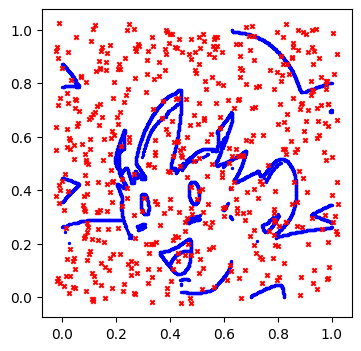

Epoch 1/50
Loss: 7.494386196136475 MeanGrad: [-0.00358415  0.00343571]


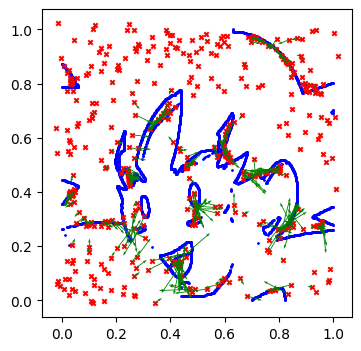

Epoch 2/50
Loss: 7.095580577850342 MeanGrad: [-0.00597081 -0.0028026 ]


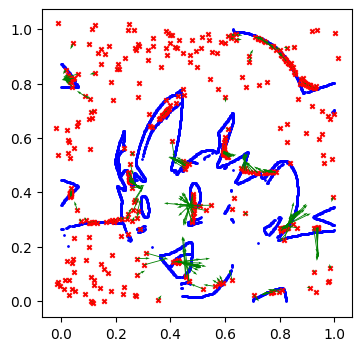

Epoch 3/50
Loss: 6.999582290649414 MeanGrad: [-0.00361366  0.00387911]


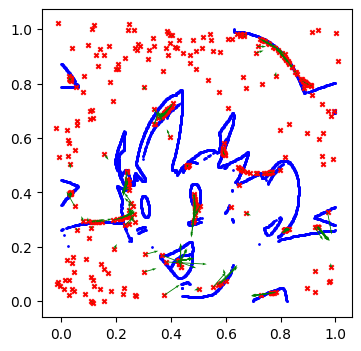

Epoch 4/50
Loss: 7.249373435974121 MeanGrad: [ 0.00621389 -0.00078743]


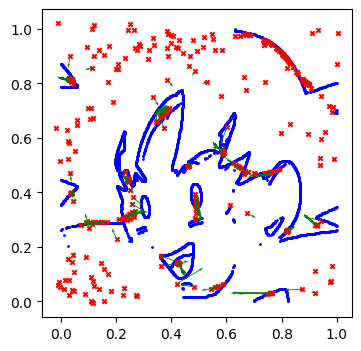

Epoch 5/50
Loss: 6.416190147399902 MeanGrad: [-0.01274976  0.00711163]


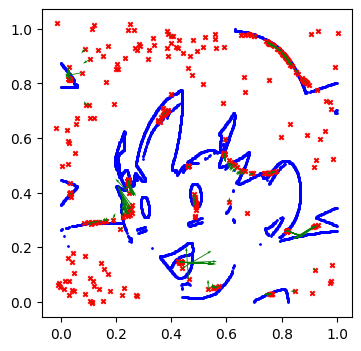

Epoch 6/50
Loss: 6.851135730743408 MeanGrad: [0.01087617 0.00934428]


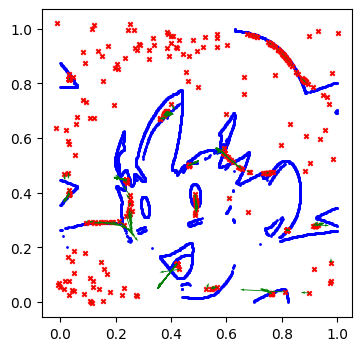

Epoch 7/50
Loss: 6.933991432189941 MeanGrad: [0.00451072 0.0008998 ]


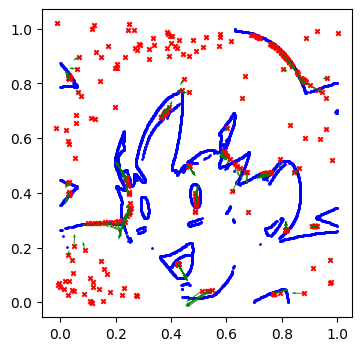

Epoch 8/50
Loss: 6.829292297363281 MeanGrad: [-0.00019028  0.00821514]


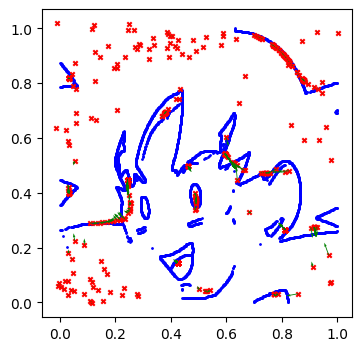

Epoch 9/50
Loss: 7.2040863037109375 MeanGrad: [0.00191237 0.00169952]


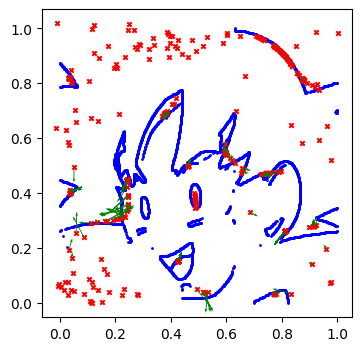

Epoch 10/50
Loss: 6.577544212341309 MeanGrad: [ 0.00399372 -0.00447502]


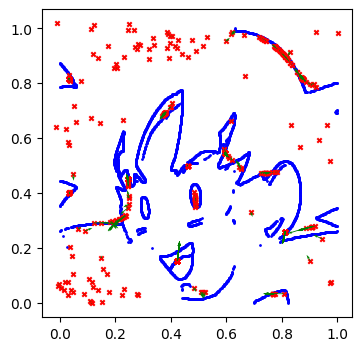

Epoch 11/50
Loss: 6.712582588195801 MeanGrad: [-0.00275906  0.0127449 ]


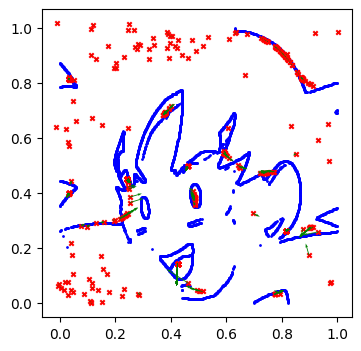

Epoch 12/50
Loss: 7.075253963470459 MeanGrad: [0.00739117 0.00246756]


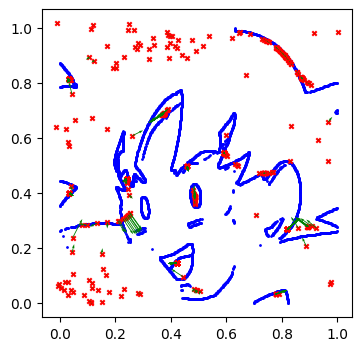

Epoch 13/50
Loss: 7.1627607345581055 MeanGrad: [-0.00113965  0.00412825]


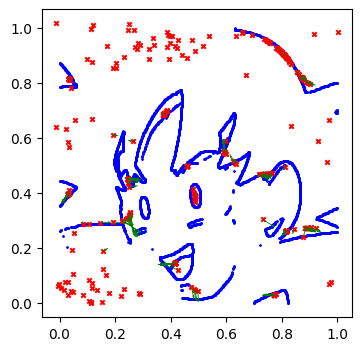

Epoch 14/50
Loss: 6.726676940917969 MeanGrad: [-0.00157167 -0.00719546]


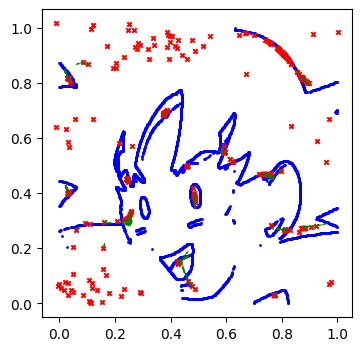

Epoch 15/50
Loss: 6.96676778793335 MeanGrad: [0.00539474 0.00220103]


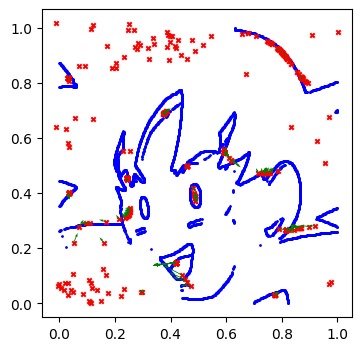

Epoch 16/50
Loss: 6.862343788146973 MeanGrad: [0.00588763 0.00629036]


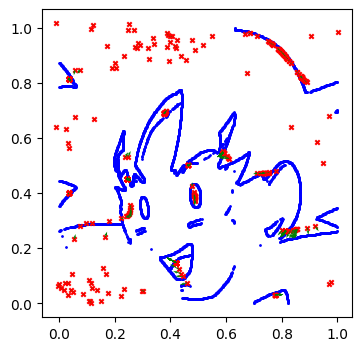

Epoch 17/50
Loss: 6.957839488983154 MeanGrad: [0.00482635 0.0161916 ]


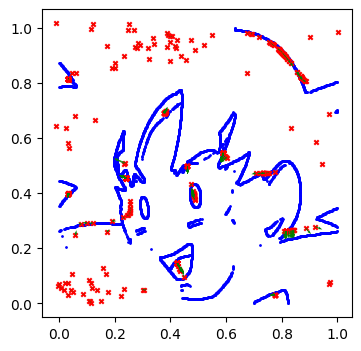

Epoch 18/50
Loss: 6.446987152099609 MeanGrad: [-0.00268655 -0.00340244]


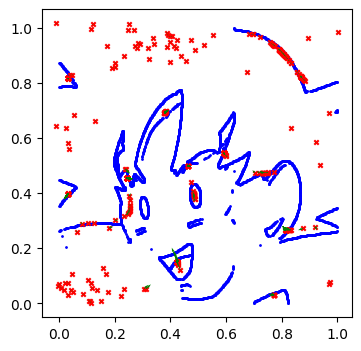

Epoch 19/50
Loss: 6.440818786621094 MeanGrad: [0.00293813 0.0104114 ]


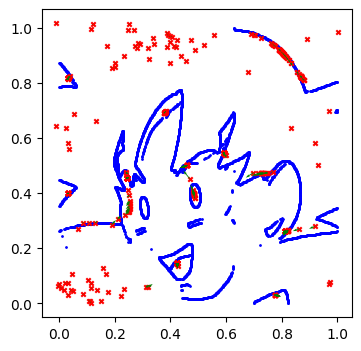

Epoch 20/50
Loss: 6.4652814865112305 MeanGrad: [-1.4892214e-02 -7.3256662e-05]


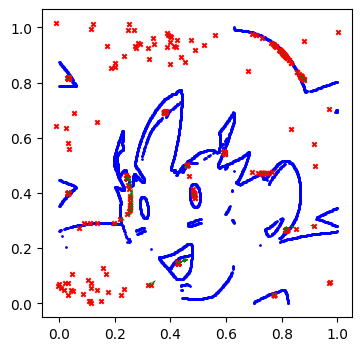

Epoch 21/50
Loss: 6.751189708709717 MeanGrad: [ 0.00352784 -0.00401535]


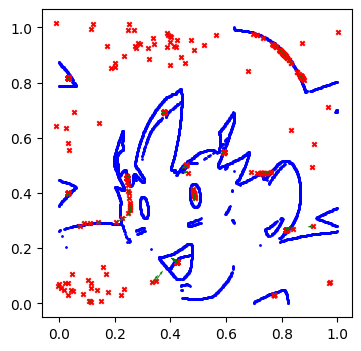

Epoch 22/50
Loss: 6.43496036529541 MeanGrad: [ 0.01161935 -0.00203872]


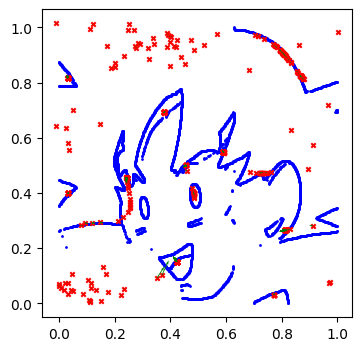

Epoch 23/50
Loss: 6.804380416870117 MeanGrad: [-0.00272913  0.01252544]


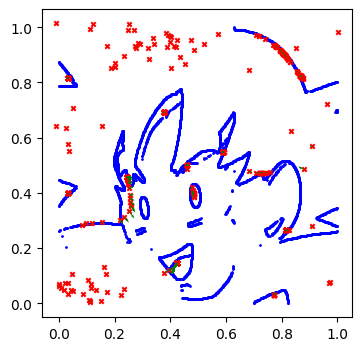

Epoch 24/50
Loss: 6.56679630279541 MeanGrad: [0.00897095 0.00796752]


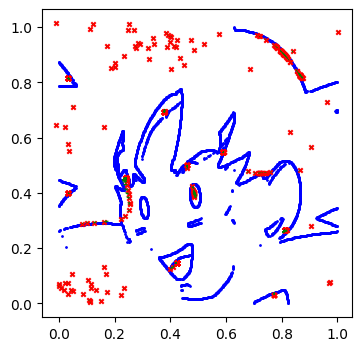

Epoch 25/50
Loss: 6.956971168518066 MeanGrad: [0.00753834 0.00372286]


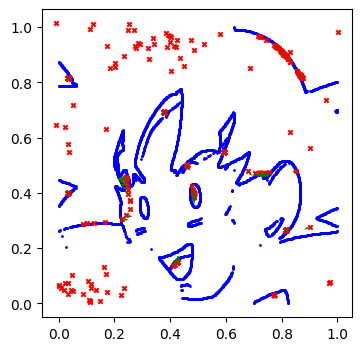

Epoch 26/50
Loss: 6.256828308105469 MeanGrad: [0.00653515 0.00211668]


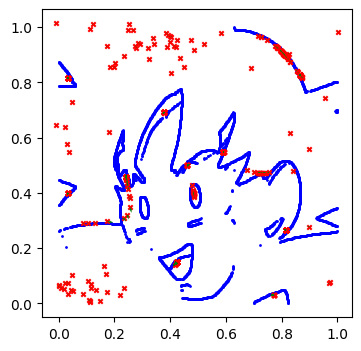

Epoch 27/50
Loss: 6.421416282653809 MeanGrad: [-0.00745682  0.02026576]


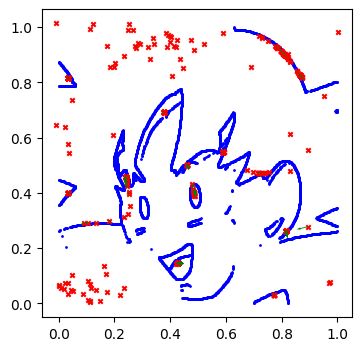

Epoch 28/50
Loss: 7.199644088745117 MeanGrad: [-0.00467289  0.0007279 ]


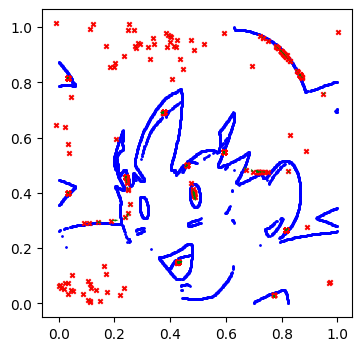

Epoch 29/50
Loss: 7.5098466873168945 MeanGrad: [0.00707007 0.00065508]


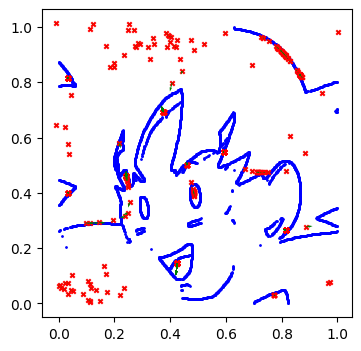

Epoch 30/50
Loss: 6.677062511444092 MeanGrad: [0.00040654 0.01167167]


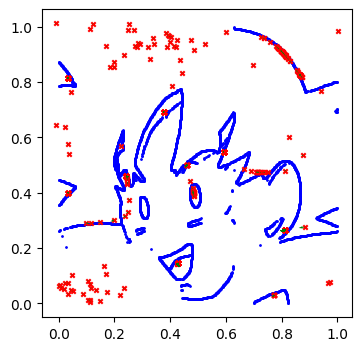

Epoch 31/50
Loss: 6.827775001525879 MeanGrad: [0.01451353 0.01917236]


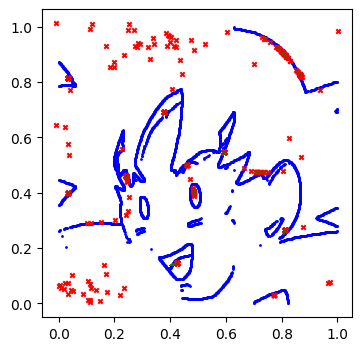

Epoch 32/50
Loss: 6.9419732093811035 MeanGrad: [-0.00037856 -0.00539936]


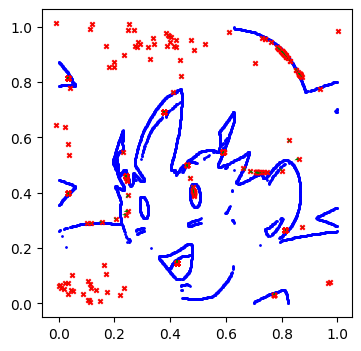

Epoch 33/50
Loss: 6.984941005706787 MeanGrad: [ 0.00097919 -0.00182078]


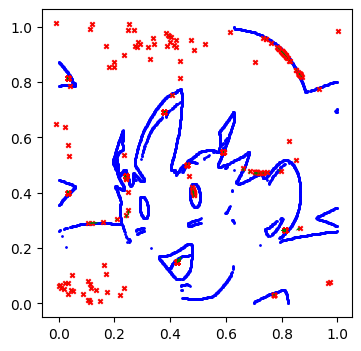

Epoch 34/50
Loss: 6.698559761047363 MeanGrad: [-0.00042279  0.00628898]


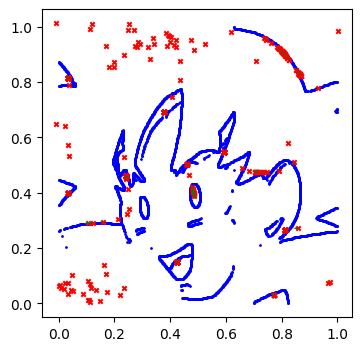

Epoch 35/50
Loss: 6.901261329650879 MeanGrad: [-0.00326494  0.00989969]


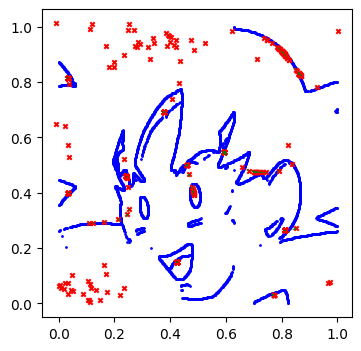

Epoch 36/50
Loss: 6.5742878913879395 MeanGrad: [-0.01474234 -0.00737349]


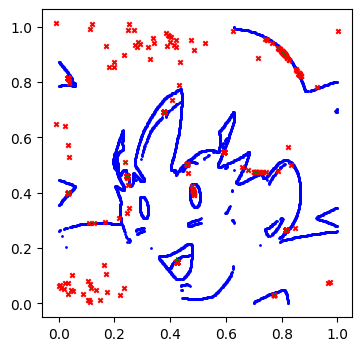

Epoch 37/50
Loss: 7.454134464263916 MeanGrad: [-0.01536981  0.01173177]


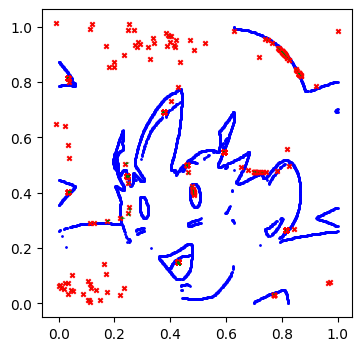

Epoch 38/50
Loss: 6.879581451416016 MeanGrad: [0.0138809  0.00392159]


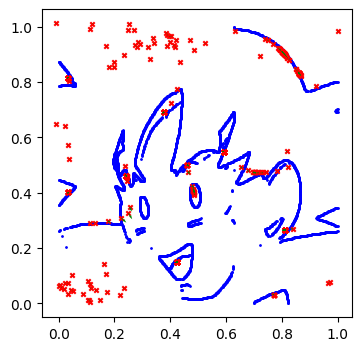

Epoch 39/50
Loss: 6.338590621948242 MeanGrad: [0.0012686  0.00455694]


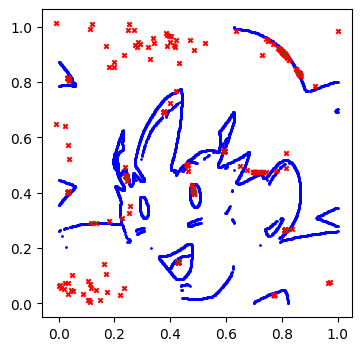

Epoch 40/50
Loss: 6.523568153381348 MeanGrad: [0.00816706 0.01738507]


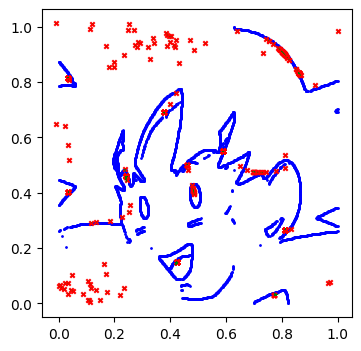

Epoch 41/50
Loss: 6.689697742462158 MeanGrad: [-0.00503562  0.01222013]


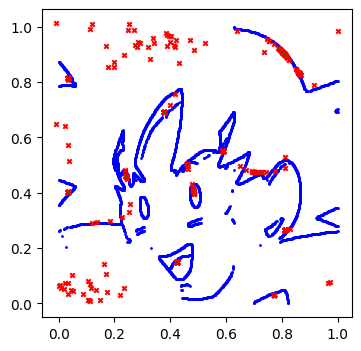

Epoch 42/50
Loss: 6.743032932281494 MeanGrad: [0.00311581 0.00811667]


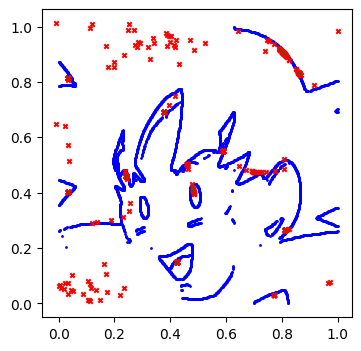

Epoch 43/50
Loss: 6.600086688995361 MeanGrad: [-0.00411683  0.00194246]


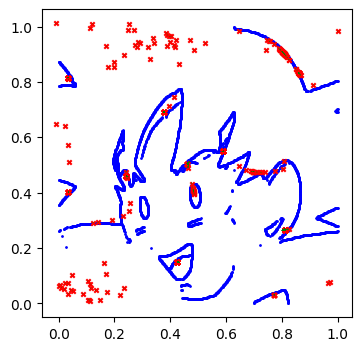

Epoch 44/50
Loss: 6.904537200927734 MeanGrad: [0.01213133 0.01937124]


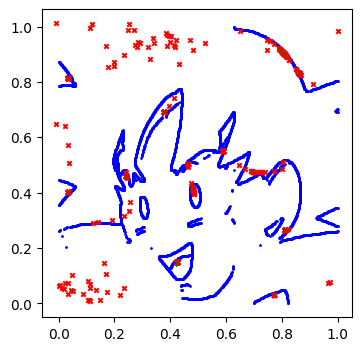

Epoch 45/50
Loss: 6.661766529083252 MeanGrad: [-0.00135956 -0.00601106]


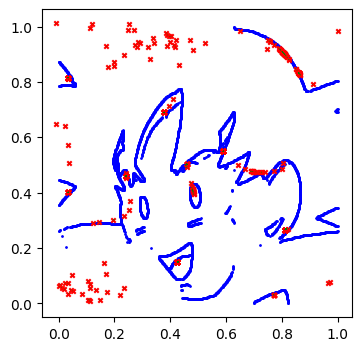

Epoch 46/50
Loss: 6.888528823852539 MeanGrad: [-0.00509888  0.02726409]


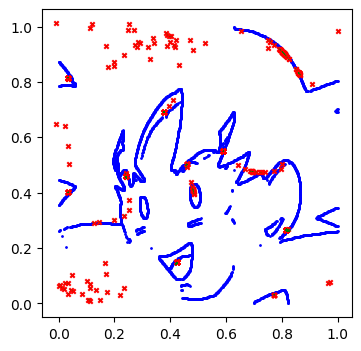

Epoch 47/50
Loss: 6.554551124572754 MeanGrad: [-0.00369021 -0.00232552]


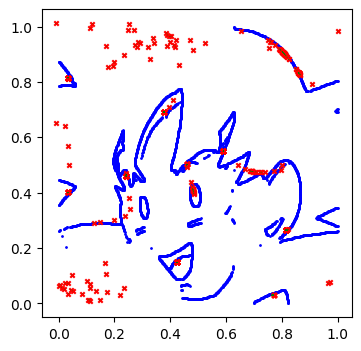

Epoch 48/50
Loss: 6.71237850189209 MeanGrad: [0.00281014 0.00559289]


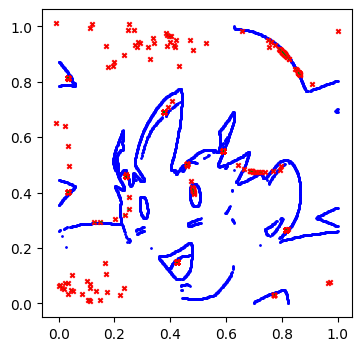

Epoch 49/50
Loss: 6.675878047943115 MeanGrad: [-0.00870853  0.00390617]


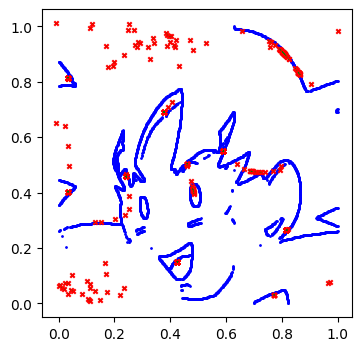

Epoch 50/50
Loss: 6.871188640594482 MeanGrad: [0.00131903 0.01533126]


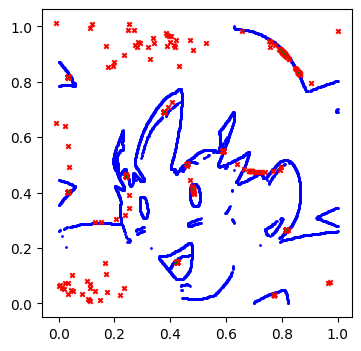

In [ ]:
Xh_ =  Xh.numpy()
plt.figure(figsize=(4,4))
plt.scatter(fcc_positions[:,0],X[:,1],c = 'b',s=30)
plt.scatter(Xh_[:,0],Xh_[:,1],c = 'r',s=10,marker='x')
plt.show()
# Custom training loop
eta0 = 1e-1
batch_size = 256
epochs = 50
decay_rate = 0.95

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
    for x_batch in tf.data.Dataset.from_tensor_slices(Xt).shuffle(buffer_size=1024).batch(batch_size):

      with tf.GradientTape() as g:
        g.watch(Xh)
        H_loss_ = H_loss(Xh,x_batch,lam_)
      grad_ = g.gradient(H_loss_, Xh)
      Xh = Xh -eta*grad_
    print(f'Loss: {H_loss_.numpy()} MeanGrad: {tf.math.reduce_mean(grad_,axis=0).numpy()}')

    Xh_ =  Xh.numpy()
    gradN = -10*eta*grad_.numpy()


    plt.figure(figsize=(4,4))
    plt.scatter(X[:,0],X[:,1],c = 'b',s=1)
    plt.scatter(Xh_[:,0],Xh_[:,1],c = 'r',s=10,marker='x')
    plt.quiver(Xh_[:,0],Xh_[:,1], gradN[:,0], gradN[:,1], color='g', scale=1, scale_units='xy', angles='xy', label='Gradient Vectors')
    plt.show()

# Tareas Luker - Sofia y Juan Lugo


## Unsupervised Deep Embedding for Clustering Analysis

https://proceedings.mlr.press/v48/xieb16.pdf

https://github.com/HaebinShin/dec-tensorflow


## Tareas Sofia:

Revisar matemática PRI

Revisar Paper Unsupervised Deep Embedding for Clustering Analysis

Implementar DEC según github compartido y aplicar sobre experimento de goku y sobre Fashion Mnist

## Tareas Juan Lugo

Revisar modelo tabnet

https://paperswithcode.com/method/tabnet

Revisar implementaciones sobre keras

https://github.com/jeyabbalas/tabnet

Aplicar sobre base de datos fifa19 curso aprendizaje de máquina para luego aplicar a Luker

## Objetivo luker

- Unir DCE/PRI sofia con Tabnet Lugo, con modelo generativo para lidear con generación de propiedades físico químicas desde espacio latente anotadores

## Tareas sofia y lugo

Revisar focal loss para lidear con datos desbalanceados

https://paperswithcode.com/method/focal-loss